In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

### 데이터 로드 (q: 15분 단위, h: 1시간 단위)

In [2]:
generation_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_generation.csv"
)
generation_q["Time"] = pd.to_datetime(generation_q["Time"], format="%Y-%m-%d %H:%M")
generation_q["Hour"] = generation_q["Time"].dt.floor("h")
generation_h = generation_q.groupby("Hour").sum(numeric_only=True)

demand_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_demand.csv"
)
demand_q["Time"] = pd.to_datetime(demand_q["Time"], format="%Y-%m-%d %H:%M")
demand_q["Hour"] = demand_q["Time"].dt.floor("h")
demand_h = demand_q.groupby("Hour").sum(numeric_only=True)

price_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_price.csv"
)
price_q["Time"] = pd.to_datetime(price_q["Time"], format="%Y-%m-%d %H:%M")

### Set

In [3]:
I = list(range(len(generation_q.columns) - 11))
T = list(generation_q['Time'].dt.hour.unique())
S = list(range(20))
prob = {s: 1 / len(S) for s in S}

### 데이터 전처리

#### Generation

In [4]:
generation_avg = np.array(
    [[generation_h[generation_h.index.hour == t].mean().iloc[i] for t in T] for i in I]
)


def generate_randomized_generation(I, T, S, generation_avg, randomness_level):
    np.random.seed(7)
    if randomness_level == "low":
        noise_factors = np.random.uniform(0.8, 1.2, size=(len(I), len(T), len(S)))
    elif randomness_level == "medium":
        noise_factors = np.random.uniform(0.5, 1.5, size=(len(I), len(T), len(S)))
    elif randomness_level == "high":
        noise_factors = np.random.uniform(0.2, 1.8, size=(len(I), len(T), len(S)))
    else:
        raise ValueError(
            "Invalid randomness level. Please choose 'low', 'medium', or 'high'."
        )

    generation_r = np.zeros((len(I), len(T), len(S)))
    for i in range(len(I)):
        for t in range(len(T)):
            for s in range(len(S)):
                generation_r[i, t, s] = generation_avg[i, t] * noise_factors[i, t, s]

    return generation_r

#### Demand

In [5]:
demand_avg = np.array(
    [[demand_h[demand_h.index.hour == t].mean().iloc[i] for t in T] for i in I]
)


def generate_randomized_demand(I, T, S, demand_avg, randomness_level):
    np.random.seed(17)
    if randomness_level == "low":
        noise_factors = np.random.uniform(0.8, 1.2, size=(len(I), len(T), len(S)))
    elif randomness_level == "medium":
        noise_factors = np.random.uniform(0.5, 1.5, size=(len(I), len(T), len(S)))
    elif randomness_level == "high":
        noise_factors = np.random.uniform(0.2, 1.8, size=(len(I), len(T), len(S)))
    else:
        raise ValueError(
            "Invalid randomness level. Please choose 'low', 'medium', or 'high'."
        )

    demand_r = np.zeros((len(I), len(T), len(S)))
    for i in range(len(I)):
        for t in range(len(T)):
            for s in range(len(S)):
                demand_r[i, t, s] = demand_avg[i, t] * noise_factors[i, t, s]

    return demand_r

#### Randomize

In [6]:
random_key = 'high'

In [7]:
generation_r = generate_randomized_generation(I, T, S, generation_avg, random_key)
demand_r = generate_randomized_demand(I, T, S, demand_avg, random_key)

#### Residual = generation - demand

In [8]:
residual = np.zeros((len(I), len(T), len(S)))
for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            residual[i, t, s] = generation_r[i, t, s] - demand_r[i, t, s]

R = np.zeros((len(I), len(T), len(S)))
for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            R[i, t, s] = max(0, residual[i, t, s])

#### Price 설정

In [9]:
price_q["Hour"] = price_q["Time"].dt.floor("h")
price_h = price_q.groupby("Hour").mean(numeric_only=True)

price = price_h.iloc[: len(S) * len(T)]

P_DA = np.array(
    [sum(price["Price"].iloc[t + s * len(T)] for s in S) / len(S) * 1.2 for t in T]
)
P_RT = np.array([[price["Price"].iloc[t + s * len(T)] for s in S] for t in T])
P_PN = np.array(
    [sum(price["Price"].iloc[t + s * len(T)] for s in S) / len(S) * 2 for t in T]
)

### 모델 DER only

In [10]:
only = gp.Model("only")
only.Params.OutputFlag = 0
only.setParam('TimeLimit', 3600)
only.setParam('Presolve', 0)

x = only.addVars(len(I), len(T), vtype=GRB.CONTINUOUS, lb=0, name="x")
y_plus = only.addVars(len(I), len(T), len(S), vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
y_minus = only.addVars(len(I), len(T), len(S), vtype=GRB.CONTINUOUS, lb=0, name="y_minus")

M = max(R[i, t, s] for i in range(len(I)) for t in range(len(T)) for s in range(len(S)))
z = only.addVars(len(I), len(T), len(S), vtype=GRB.BINARY, name="z")

only.update()

obj = gp.quicksum(
    P_DA[t] * x[i, t] for i in range(len(I)) for t in range(len(T))
) + gp.quicksum(
    prob[s] * (P_RT[t, s] * y_plus[i, t, s] - P_PN[t] * y_minus[i, t, s])
    for i in range(len(I))
    for t in range(len(T))
    for s in range(len(S))
)

only.setObjective(obj, GRB.MAXIMIZE)

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20


In [11]:
for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            only.addConstr(R[i, t, s] - x[i, t] == y_plus[i, t, s] - y_minus[i, t, s])

for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            only.addConstr(y_plus[i, t, s] <= R[i, t, s])

for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            only.addConstr(y_plus[i, t, s] <= M * z[i, t, s])
            only.addConstr(y_minus[i, t, s] <= M * (1 - z[i, t, s]))

only.optimize()

if only.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"Objective value: {only.objVal}")
else:
    print("No optimal solution found.")

Optimal solution found!
Objective value: 10662.081463159064


### 결과 분석

#### 수익 분석

In [12]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for i in range(len(I)):
    for t in range(len(T)):
        total_da_profit_obj += P_DA[t] * x[i,t].x

# Real-time 수익 비교
total_rt_profit_obj = 0
for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            rt_profit_obj = P_RT[t, s] * y_plus[i, t, s].x
            total_rt_profit_obj += prob[s] * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            penalty_cost_obj = P_PN[t] * y_minus[i, t, s].x
            total_penalty_cost_obj += prob[s] * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj

# 결과 출력
print(f"DA: {total_da_profit_obj:.2f}")
print(f"RT: {total_rt_profit_obj:.2f}")
print(f"Penalty: {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

DA: 1007.91
RT: 9931.55
Penalty: 277.38
목적 함수 기반 총 이익 (_obj): 10662.08


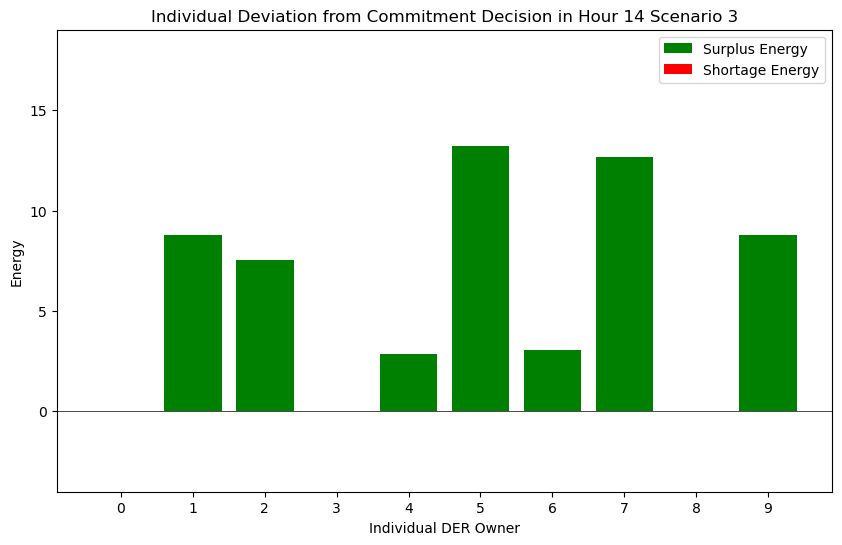

In [13]:
# ✅ 특정 시간과 시나리오 선택
t_target = 14  # 원하는 시간 (예: 13시)
s_target = 3  # 원하는 시나리오 (예: 시나리오 3)

# ✅ 개별 DER owner들의 y_plus와 y_minus 값 추출
y_plus_values = [y_plus[i, t_target, s_target].x for i in range(len(I))]
y_minus_values = [
    -y_minus[i, t_target, s_target].x for i in range(len(I))
]  # Shortage는 음수로 변환

# ✅ DER owner 인덱스
der_indices = np.arange(len(I))

# ✅ Figure 설정
fig, ax = plt.subplots(figsize=(10, 6))

# ✅ Surplus (y_plus) -> 초록색
ax.bar(der_indices, y_plus_values, color="green", label="Surplus Energy")

# ✅ Shortage (y_minus) -> 빨간색
ax.bar(der_indices, y_minus_values, color="red", label="Shortage Energy")

# ✅ 0 기준선 추가
ax.axhline(0, color="black", linewidth=0.5)

# ✅ 레이블 및 축 설정
ax.set_xlabel("Individual DER Owner")
ax.set_ylabel("Energy")
ax.set_xticks(der_indices)  # DER owner 인덱스 설정
ax.legend()
ax.set_ylim(-4, 19)

# ✅ 제목 추가
plt.title(
    f"Individual Deviation from Commitment Decision in Hour {t_target} Scenario {s_target}"
)

# ✅ 그래프 출력
plt.show()

#### 하루 개인별 커밋량 합 분석

In [14]:
sum_x = 0
for t in T:
    time_sum = sum(x[i,t].x for i in I)
    print(f"시간 {t}: {time_sum}")
    sum_x += time_sum
print(f"총 하루 commitment: {sum_x:.2f}")


시간 0: 0.0
시간 1: 0.0
시간 2: 0.0
시간 3: 0.0
시간 4: 0.0
시간 5: 0.0
시간 6: 0.0
시간 7: 0.0
시간 8: 0.0
시간 9: 0.5147986034749454
시간 10: 1.1537325783348145
시간 11: 4.468186031172859
시간 12: 8.480075496175662
시간 13: 5.14820899283779
시간 14: 4.1076077229136345
시간 15: 0.0995089161398921
시간 16: 0.5935178075250587
시간 17: 0.0
시간 18: 0.0
시간 19: 0.0
시간 20: 0.0
시간 21: 0.0
시간 22: 0.0
시간 23: 0.0
총 하루 commitment: 24.57


#### 개인 수익 분석

In [15]:
# 모든 der의 profit 합계 계산
total_der_profit = 0
der_profit = {}
for i in range(len(I)):
    # 각 der i의 profit 합계 계산
    der_profit[i] = sum(P_DA[t] * x[i,t].x + sum(prob[s] * (P_RT[t,s] * y_plus[i,t,s].x - P_PN[t] * y_minus[i,t,s].x) for s in range(len(S))) for t in range(len(T)))
    total_der_profit += der_profit[i]

print("\nder_profit:")
for i in range(len(I)):
    print(f"[{i}] {der_profit[i]:.2f}")

print(f"\n모든 der의 profit 합계: {total_der_profit:.2f}")



der_profit:
[0] 1204.52
[1] 872.55
[2] 1237.50
[3] 1128.51
[4] 724.24
[5] 963.51
[6] 1732.71
[7] 1098.93
[8] 768.93
[9] 930.68

모든 der의 profit 합계: 10662.08


### 결과 저장

In [16]:
# R_sum = {(i, t): sum(R[i, t, s] for s in S) / len(S) for i in I for t in T}
# R_df = pd.DataFrame({i: {t: R_sum[i, t] for t in T} for i in I})
# R_df.to_csv('result_R.csv', index=False)

# pd.DataFrame(list(P_DA.items()), columns=['time', 'price']).to_csv('result_P_DA.csv', index=False)

total_x_only = {t: sum(x[i,t].x for i in I) for t in T}
total_x_only_df = pd.DataFrame({'total_x_only': total_x_only})
total_x_only_df.to_csv('result/result_base_totalX.csv', index=False)

only_profit_value = pd.DataFrame({'only_profit_value': der_profit})
only_profit_value.to_csv('result/result_only_profit.csv', index=False)

only_obj = pd.DataFrame({'only_obj': [only.objVal]})
only_obj.to_csv('result/result_only_obj.csv', index=False)
